In [2]:
import json

import nptsne
import numpy as np
from nptsne import hsne_analysis
import pandas as pd


In [3]:
X = np.load("C:\\Users\\alexa\\Desktop\\EPIC-Kitchen100\\Val_set_hsne\\feats_val_set.npy")
GT_LABELS = pd.read_csv("C:\\Users\\alexa\\Desktop\\EPIC-Kitchen100\\Val_set_hsne\\anno_val_set_segm.csv", header=0)

In [4]:
def create_hsne(scales = 3):
    print(f'Size data: {X.shape}')
    hsne = nptsne.HSne(True)
    hsne.create_hsne(X, scales)
    print(f'Num scales: {hsne.num_scales} Num points {hsne.num_data_points}')
    return hsne

In [5]:
def create_top_analysis(hsne, iterations = 500):
    top_analysis = nptsne.hsne_analysis.Analysis(hsne,nptsne.hsne_analysis.EmbedderType.GPU)
    for i in range(iterations):
        top_analysis.do_iteration()
    return top_analysis

In [6]:
def get_total_labels_per_class():
    unique, counts = np.unique(GT_LABELS["segment_gt_label"], return_counts=True)
    total_labels = dict(zip(unique, counts))
    return total_labels

def get_true_labels_for_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]

def find_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    unique, counts = np.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"], return_counts=True)
    return dict(zip(unique,counts))

def find_number_of_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return len(pd.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]))

In [7]:
hsne = nptsne.HSne(True)
hsne.load_hsne(X,"C:\\Users\\alexa\\Desktop\\Thumos14\\features_test_set.hsne")
top_analysis = create_top_analysis(hsne)

In [8]:
# embedding_with_indexes = list(zip(top_analysis.embedding, top_analysis.landmark_indexes))

In [9]:
# embedding_with_indexes_sorted = sorted(embedding_with_indexes, key = lambda x: (x[0][0], x[0][1]))

In [10]:
# def split_into_chunks(size_of_chunk = 278):
#     split_indexes = []
#     for i in range(len(embedding_with_indexes_sorted)//size_of_chunk):
#         current_list = []
#         for j in range(size_of_chunk):
#             if i * size_of_chunk + j >= len(embedding_with_indexes_sorted):
#                 if len(current_list) > 0:
#                     split_indexes.append(current_list)
#                 break
#             current_list.append(embedding_with_indexes_sorted[i*size_of_chunk + j][1])
#         split_indexes.append(current_list)
#     return split_indexes

In [8]:
def create_new_analysis(hsne, points, parent_analysis, iterations = 500):
    new_analysis = nptsne.hsne_analysis.Analysis(hsne, embedder_type= nptsne.hsne_analysis.EmbedderType.GPU, parent=parent_analysis, parent_selection=points)
    for i in range(iterations):
        new_analysis.do_iteration()
    return new_analysis

In [9]:
from sklearn.cluster import KMeans
def create_clustering(analysis, n_clusters):
    points = analysis.embedding
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(points)
    return kmeans

C:\Users\alexa\anaconda3\envs\HSNE\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


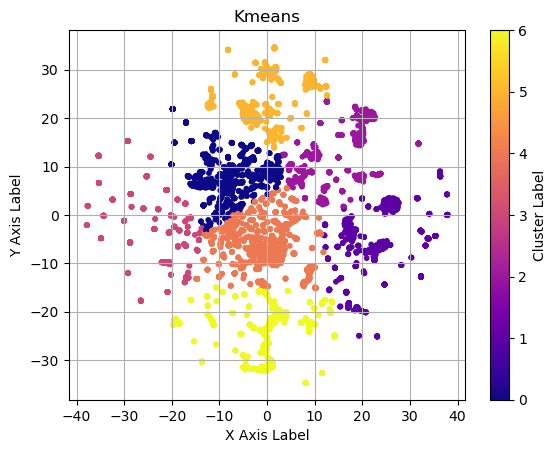

In [22]:
# import matplotlib.pyplot as plt
# kmeans = create_clustering(top_analysis, 7)
# points = top_analysis.embedding
# cluster_labels_kmeans = kmeans.labels_
# plt.scatter(points[:, 0], points[:, 1], c=cluster_labels_kmeans, cmap='plasma', s=10)
# plt.title('Kmeans')
# plt.xlabel('X Axis Label')
# plt.ylabel('Y Axis Label')
# plt.colorbar(label='Cluster Label')
# plt.grid(True)
# plt.show()


In [10]:
class ComparableAnalysis:
    def __init__(self, number_of_points, analysis):
        self.number_of_points = number_of_points
        self.analysis = analysis
    
    def __lt__(self, other):
        return self.number_of_points < other.number_of_points
    
    def __eq__(self, other):
        return self.analysis.id == other.analysis.id

In [25]:
import queue

def bfs(hsne, top_analysis, always_most_points = False, dfs = True):
    final_indexes = []
    if dfs:
        queue_analysis = queue.LifoQueue()
    elif always_most_points:
        queue_analysis = queue.PriorityQueue()
    else:
        queue_analysis = queue.Queue()
    queue_analysis.put(ComparableAnalysis(top_analysis.number_of_points, top_analysis))
    while not queue_analysis.empty():
        current_analysis = queue_analysis.get().analysis
        print(current_analysis.scale_id)
        if current_analysis.scale_id == 0:
            final_indexes.append(current_analysis.landmark_orig_indexes)
        if current_analysis.number_of_points >= 1:
            if current_analysis.scale_id == 2:
                clustering = create_clustering(current_analysis, n_clusters=8)
                for label in np.unique(clustering.labels_):
                    new_points = np.where(clustering.labels_ == label)[0]
                    iterations = 500
                    if len(new_points) < 50:
                        iterations = 50
                    temp_analysis = create_new_analysis(hsne,new_points.tolist(),current_analysis, iterations)
                    #multiplied by -1 so I get inverse order for the PriorityQueue
                    queue_analysis.put(ComparableAnalysis(-1 * temp_analysis.number_of_points, temp_analysis))
            elif current_analysis.scale_id == 1:
                new_points = list(range(current_analysis.number_of_points))
                iterations = 500
                if len(new_points) < 50:
                    iterations = 50
                temp_analysis = create_new_analysis(hsne,new_points,current_analysis, iterations)
                queue_analysis.put(ComparableAnalysis(-1 * temp_analysis.number_of_points, temp_analysis))
    return final_indexes

In [26]:
final_indexes = bfs(hsne,top_analysis)
# np.save("final_indexes.npy",final_indexes)

2


C:\Users\alexa\anaconda3\envs\HSNE\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


In [30]:
# print(len(final_indexes))
# for index in final_indexes:
#     print(index[:100])

8
[342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441]
[ 252  253  254  255  256  299  300  301 4985 5272 5273 5274 5275 5276
 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290
 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304
 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318
 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332
 5333 5334 5335 5336 5337 5338 5339 5340 5341 5342 5343 5344 5345 5346
 5347 5348 5349 5350 5351 5353 5354 5355 5356 5357 5358 5359 5360 5361
 5362 5363]
[4365 4366 4367 4368 4369 4370 4371 4372 4373 4374 4375 4376 4377 4378
 4379 4380 

In [32]:
import os
import shutil

for i,final_index in enumerate(final_indexes):
    print(i)
    np.save(f"C:\\Users\\alexa\\Desktop\\Thumos14\\hsne_analysis_25000\\hsne_{i}",X[list(final_index)])
    os.makedirs(f"C:\\Users\\alexa\\Desktop\\Thumos14\\hsne_analysis_25000\\frames_{i}",)
    for j,index in enumerate(final_index):
        shutil.copy(f"C:\\Users\\alexa\\Desktop\\Thumos14\\frames\\{index}.jpg", f"C:\\Users\\alexa\\Desktop\\Thumos14\\hsne_analysis_25000\\frames_{i}\\{j}.jpg")
        
    

0
1
2
3
4
5
6
7


In [ ]:
# chunks = split_into_chunks(100)
# new_analyses = []
# final_indexes = []
# intermediate_analysis = []
# for chunk in chunks:
#     analysis = create_new_analysis(hsne, chunk, top_analysis, 1)
#     if analysis.number_of_points != 0:
#         # intermediate_analysis.append(analysis)
#         final_analysis = create_new_analysis(hsne, analysis.landmark_indexes, analysis, 1)
#         if final_analysis.number_of_points != 0:
#             print(final_analysis.landmark_orig_indexes)
#             final_indexes.append(final_analysis.landmark_orig_indexes)
# np.save("final_indexes.npy",final_indexes)

[1428 1433 1436 1437 1440 1441 1443 1444 1466 1467 1469 1470 1471 1472
 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486
 1487 1488 1489 1490 1491 1492 1493 1494 1495 1497 1498 1499 1502 1503
 1504 1505 1506 1507 1509 1646 1647 1648 1649 1650 1651 1652 1653 1654
 1655 1656 1657 1658 1659 1660 1661 1662 3297 3700 3701 3846 3847 3878
 3879 3880 3881 3882 3883 3884 3885 3886 3887 3888 3889 3890 3891 3892
 4419 4517 6723]
[   387    388    389    390    391    392    393    394    395    396
    397    398    399    400    401    402    403    404    405    406
    407    408    409    410    411    412    413    414    415    416
    417    418    419    420    421    422    423    424    425    426
    427    428    429    430    431    432    433    434    435    436
    437    438    439    440    441    442    443    444    445    446
    447    448    449    450    451    452    453    454    455    456
    457    458    459    460    461    462    463    464    

In [1]:
# final_indexes = []
# for analysis in intermediate_analysis:
#     final_analysis = create_new_analysis(hsne, analysis.landmark_indexes.tolist(), analysis, 500)
#     final_indexes.append(final_analysis.landmark_orig_indexes.tolist())
#     print(final_analysis.landmark_orig_indexes)

NameError: name 'intermediate_analysis' is not defined

In [22]:
# for i,final_index in enumerate(final_indexes):
#     print(len(final_index))
#     # with open(f"C:\\Users\\alexa\\Desktop\\Thumos14\\hsne_analysis\\hsne_data_{i}.npy", "wb") as file:
#     #     np.save(file,X[final_index])

3612
647
125
134
432
156
262
0
26
1232
445
212
798
2211
292
336
681
413
